# demo_01_segment_patches

A demonstration of running the ADP tuning set through HistoSegNet and evaluating the results qualitatively and quantitatively.

## Setup

In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hsn_v1
import pandas as pd
import numpy as np

from hsn_v1.adp import Atlas
from hsn_v1.utilities import *
from hsn_v1.histonet import HistoNet
from hsn_v1.gradcam import GradCAM
from hsn_v1.densecrf import DenseCRF

Using TensorFlow backend.


In [3]:
import tensorflow as tf

In [4]:
tf.test.is_gpu_available()

True

## Initialize HistoSegNet

* `input_name` $\in$ {'01_tuning_patch', '02_glas_full'}: the segmentation set to be solved
* `input_size` $\in$ [int > 0, int > 0]: the resized size of the input image
* `input_mode` $\in$ {'patch', 'wsi'}: the type of input image, either patch ('patch') or slide ('wsi'); only patches supported in public code release
* `down_fac` $\in$ 0 $\leq$ float $\leq$ 1: the scalar by which to downsample the input image to ensure equivalent pixel resolution (1.2143 um/px / input pixel resolution)
* `batch_size` $\in$ int > 0: batch size of input images
* `htt_mode` $\in$ {'both', 'morph', 'func', 'glas'}: the type of classes to segment from the images: both morphological and functional types ('both'), only morphological types ('morph'), only functional types ('func'), and glandular/non-glandular ('glas')
* `gt_mode` $\in$ {'on', 'off'}: whether to assess the segmentation against the ground-truth annotations, either 'on' or 'off'
* `run_level` $\in$ {1, 2, 3}: the final stage to run in HistoSegNet: the first stage/CNN confidence scores (1), the third stage/modified Grad-CAMs (2), or the fourth stage/dense CRF segmentation masks (3)
* `save_types` $\in$ [{0, 1}, {0, 1}, {0, 1}, {0, 1}]: the types of files to save for debugging, as a list of four binary values (0/1)
  1. HTT confidence scores: save (1), do not save (0)
  2. Continuous Grad-CAMs: save (1), do not save (0)
  3. Discrete segmentation masks: save (1), do not save (0)
  4. Summary images: save (1), do not save (0)
* `verbosity` $\in$ {'NORMAL', 'QUIET'}: the verbosity of debug messages, either on ('NORMAL') or off ('QUIET')

In [5]:
hsn = hsn_v1.HistoSegNetV1(params={'input_name': '01_tuning_patch', 'input_size': [224, 224], 
                                   'input_mode': 'patch', 'down_fac': 1, 'batch_size': 16, 
                                   'htt_mode': 'both', 'gt_mode': 'on', 'run_level': 3, 
                                   'save_types': [0, 0, 1, 0], 'verbosity': 'QUIET'})

In [122]:
hsn = hsn_v1.HistoSegNetV1(params={'input_name': 'img_1', 'input_size': [224, 224], 
                                   'input_mode': 'patch', 'down_fac': 1, 'batch_size': 16, 
                                   'htt_mode': 'both', 'gt_mode': 'off', 'run_level': 3, 
                                   'save_types': [0, 0, 1, 0], 'verbosity': 'QUIET'})

## Load images

Load images from file

In [123]:
hsn.find_img()
hsn.input_files_all

['temp_2_1.png',
 'temp_1_3.png',
 'temp_0_2.png',
 'temp_1_2.png',
 'temp_1_1.png',
 'temp_0_1.png',
 'temp_3_0.png',
 'temp_0_3.png',
 'temp_2_3.png',
 'temp_2_0.png',
 'temp_0_0.png',
 'temp_3_1.png',
 'temp_3_3.png',
 'temp_1_0.png',
 'temp_3_2.png',
 'temp_2_2.png']

Obtain logarithmic inverse class frequencies

In [124]:
hsn.analyze_img()

Display logarithmic inverse class frequencies for the morphological types

In [125]:
df = pd.DataFrame(data=hsn.httclass_loginvfreq[0], index=hsn.httclass_valid_classes[0], columns=np.array([hsn.htt_classes[0]]))
df

AttributeError: 'HistoSegNetV1' object has no attribute 'httclass_loginvfreq'

Display logarithmic inverse class frequencies for the functional types

In [126]:
df = pd.DataFrame(data=hsn.httclass_loginvfreq[1], index=hsn.httclass_valid_classes[1], columns=np.array([hsn.htt_classes[1]]))
df

AttributeError: 'HistoSegNetV1' object has no attribute 'httclass_loginvfreq'

## Load CNN

In [127]:
!pip show h5py

Name: h5py
Version: 2.10.0
Summary: Read and write HDF5 files from Python
Home-page: http://www.h5py.org
Author: Andrew Collette
Author-email: andrew.collette@gmail.com
License: BSD
Location: /home/jt/anaconda3/lib/python3.8/site-packages
Requires: six, numpy
Required-by: 


In [128]:
hsn.load_histonet(params={'model_name': 'histonet_X1.7_clrdecay_5'})
print(hsn.hn.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
__________

Print the loaded class score thresholds

In [129]:
df = pd.DataFrame(data=hsn.hn.thresholds[0], index=hsn.atlas.level5)
df

,0
E,0.720844
E.M,0.656404
E.M.S,0.420312
E.M.U,0.419097
E.M.O,0.428349
E.T,0.603345
E.T.S,0.333333
E.T.U,0.489809
E.T.O,0.333333
E.P,0.333333


## Run all batches

In [75]:
confscores = np.zeros((len(hsn.input_files_all), len(hsn.hn.class_names)))
iou = {}
fiou = {}
miou = {}
num_batches = (len(hsn.input_files_all) + hsn.batch_size - 1) // hsn.batch_size
for iter_batch in range(num_batches):
    start = iter_batch * hsn.batch_size
    end = min((iter_batch + 1) * hsn.batch_size, len(hsn.input_files_all))
    hsn.input_files_batch = hsn.input_files_all[start:end]
    # Normalize image batch
    hsn.load_norm_imgs()
    # Load ground-truth annotations
    hsn.load_gt()
    # Segment image
    hsn.segment_img()
    # Evaluate segmentation
    iou['GradCAM'], fiou['GradCAM'], miou['GradCAM'] = hsn.eval_segmentation(hsn.intersect_counts['GradCAM'], hsn.union_counts['GradCAM'],
                                                                             hsn.confusion_matrix['GradCAM'], hsn.gt_counts['GradCAM'],
                                                                             httclass_pred_segmasks=hsn.ablative_segmasks['GradCAM'], tag_name='GradCAM')
    iou['Adjust'], fiou['Adjust'], miou['Adjust'] = hsn.eval_segmentation(hsn.intersect_counts['Adjust'], hsn.union_counts['Adjust'],
                                                                          hsn.confusion_matrix['Adjust'], hsn.gt_counts['Adjust'],
                                                                          httclass_pred_segmasks=hsn.ablative_segmasks['Adjust'], tag_name='Adjust')
    iou['CRF'], fiou['CRF'], miou['CRF'] = hsn.eval_segmentation(hsn.intersect_counts['CRF'], hsn.union_counts['CRF'],
                                                                 hsn.confusion_matrix['CRF'], hsn.gt_counts['CRF'],
                                                                 httclass_pred_segmasks=hsn.ablative_segmasks['CRF'], tag_name='CRF')

## Run all batches without GT

In [130]:
confscores = np.zeros((len(hsn.input_files_all), len(hsn.hn.class_names)))
iou = {}
fiou = {}
miou = {}
num_batches = (len(hsn.input_files_all) + hsn.batch_size - 1) // hsn.batch_size
for iter_batch in range(num_batches):
    start = iter_batch * hsn.batch_size
    end = min((iter_batch + 1) * hsn.batch_size, len(hsn.input_files_all))
    hsn.input_files_batch = hsn.input_files_all[start:end]
    # Normalize image batch
    hsn.load_norm_imgs()
    # Segment image
    hsn.segment_img()
    

## Qualitative performance

### Original images and Ground-truth annotations

Display original image, morphological ground truth, and functional ground truth annotations

In [131]:
hsn.input_files_batch

['temp_2_1.png',
 'temp_1_3.png',
 'temp_0_2.png',
 'temp_1_2.png',
 'temp_1_1.png',
 'temp_0_1.png',
 'temp_3_0.png',
 'temp_0_3.png',
 'temp_2_3.png',
 'temp_2_0.png',
 'temp_0_0.png',
 'temp_3_1.png',
 'temp_3_3.png',
 'temp_1_0.png',
 'temp_3_2.png',
 'temp_2_2.png']

In [132]:
hsn.input_images.shape

(16, 224, 224, 3)

AttributeError: 'HistoSegNetV1' object has no attribute 'httclass_gt_segmasks'

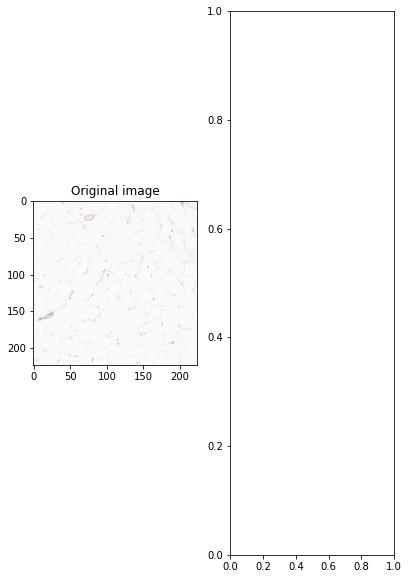

In [118]:
plt.figure(figsize=[10,10])
plt.subplot(131)
plt.imshow(hsn.input_images[1].astype('uint8'))
plt.title('Original image')
plt.subplot(132)
plt.imshow(hsn.httclass_gt_segmasks[0][1].astype('uint8'))
plt.title('Morphological\n ground truth')
plt.subplot(133)
plt.imshow(hsn.httclass_gt_segmasks[1][1].astype('uint8'))
plt.title('Functional\n ground truth')

### Predicted segmentations, stage-by-stage

Display the predicted segmentations after Stages 2, 3, and 4 for a sample image, for the morphological types

Text(0.5, 1.0, '(4) Segmentation\n Post-Processing\n(morphological)')

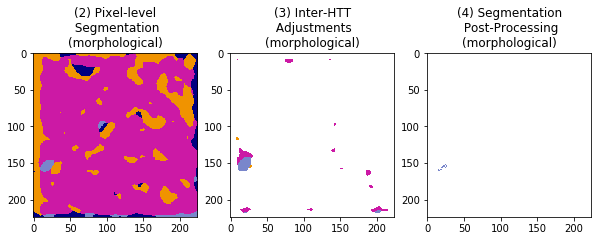

In [117]:
plt.figure(figsize=[10,10])
plt.subplot(131)
plt.imshow(hsn.ablative_segmasks['GradCAM'][0][1])
plt.title('(2) Pixel-level\n Segmentation\n(morphological)')
plt.subplot(132)
plt.imshow(hsn.ablative_segmasks['Adjust'][0][1])
plt.title('(3) Inter-HTT\n Adjustments\n(morphological)')
plt.subplot(133)
plt.imshow(hsn.ablative_segmasks['CRF'][0][1])
plt.title('(4) Segmentation\n Post-Processing\n(morphological)')

Text(0.5, 1.0, '(4) Segmentation\n Post-Processing\n(morphological)')

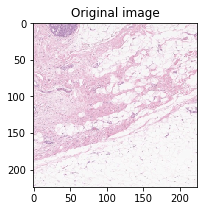

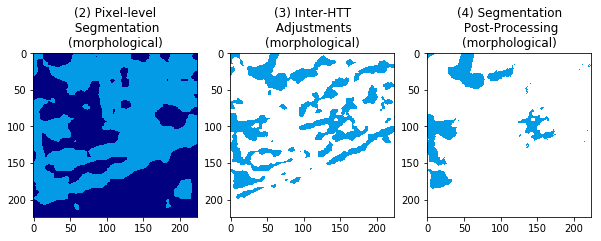

In [140]:
item_no = 6
plt.figure(figsize=[10,10])
plt.subplot(131)
plt.imshow(hsn.input_images[item_no].astype('uint8'))
plt.title('Original image')
plt.figure(figsize=[10,10])
plt.subplot(131)
plt.imshow(hsn.ablative_segmasks['GradCAM'][0][item_no])
plt.title('(2) Pixel-level\n Segmentation\n(morphological)')
plt.subplot(132)
plt.imshow(hsn.ablative_segmasks['Adjust'][0][item_no])
plt.title('(3) Inter-HTT\n Adjustments\n(morphological)')
plt.subplot(133)
plt.imshow(hsn.ablative_segmasks['CRF'][0][item_no])
plt.title('(4) Segmentation\n Post-Processing\n(morphological)')

Display the predicted segmentations after Stages 2, 3, and 4 for a sample image, for the functional types

Text(0.5, 1.0, '(4) Segmentation\n Post-Processing\n(functional)')

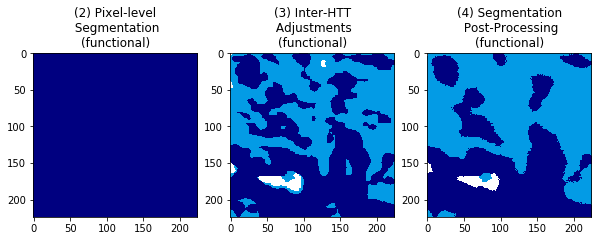

In [27]:
plt.figure(figsize=[10,10])
plt.subplot(131)
plt.imshow(hsn.ablative_segmasks['GradCAM'][1][0])
plt.title('(2) Pixel-level\n Segmentation\n(functional)')
plt.subplot(132)
plt.imshow(hsn.ablative_segmasks['Adjust'][1][0])
plt.title('(3) Inter-HTT\n Adjustments\n(functional)')
plt.subplot(133)
plt.imshow(hsn.ablative_segmasks['CRF'][1][0])
plt.title('(4) Segmentation\n Post-Processing\n(functional)')

## Quantitative performance

### Morphological types

Class IoU

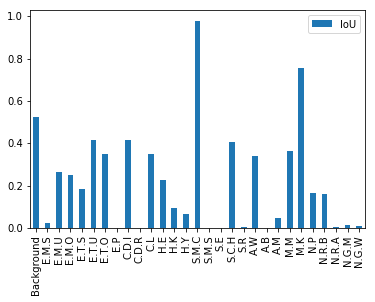

In [17]:
df = pd.DataFrame(data=iou['CRF'][0], index=hsn.httclass_valid_classes[0], columns=np.array(['IoU']))
df.plot.bar(y='IoU')

Frequency-weighted IoU

In [18]:
fiou['CRF'][0]

0.20567512794910103

Mean IoU

In [19]:
miou['CRF'][0]

0.22060558609153738

### Functional types

Class IoU

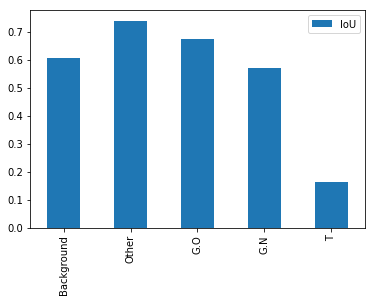

In [20]:
df = pd.DataFrame(data=iou['CRF'][1], index=hsn.httclass_valid_classes[1], columns=np.array(['IoU']))
df.plot.bar(y='IoU')

Frequency-weighted IoU

In [81]:
fiou['CRF'][1]

0.5421907340302532

Mean IoU

In [82]:
miou['CRF'][1]

0.5505619178958765

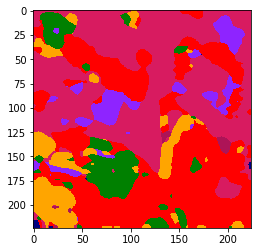

In [51]:
plt.imshow(hsn.ablative_segmasks['GradCAM'][0][0])

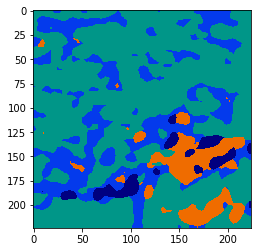

In [52]:
plt.imshow(hsn.ablative_segmasks['GradCAM'][0][1])

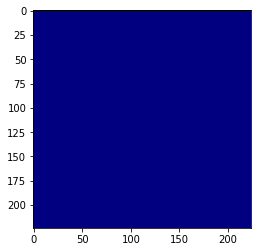

In [53]:
plt.imshow(hsn.ablative_segmasks['GradCAM'][1][0])

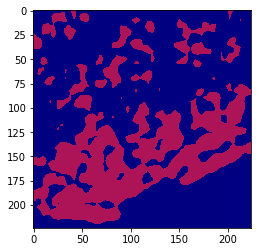

In [54]:
plt.imshow(hsn.ablative_segmasks['GradCAM'][1][1])